In [12]:
import sys
sys.path.append('..')
import itertools, copy
import re
import json
import numpy as np
import scipy.misc
from scipy.stats import binom
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('../peptidome.mplstyle')

from lib import *
from lib.maxent import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
humanseqs = [s for s in fasta_iter(human, returnheader=False)]


In [4]:
train, test = train_test_split(humanseqs, test_size=0.5)


In [107]:
k = 3
aacountss = []
#for seq in np.random.choice(humanseqs, 1000, replace=False):
for seq in train:
    seq = seq.strip('X')
    if not isvalidaa(seq):
        seq = re.sub('X|U', '', seq)
        if not isvalidaa(seq):
            print(seq)
    seq = map_aatonumber(seq)
    for i in range(len(seq)-k):
        #if isvalidaa(seq[i:i+k]):
        #print(seq[i:i+k], aacounts(seq[i:i+k]))
        aacountss.append(aacounts_int(seq[i:i+k]))

A 0.052869612410112614 [0.80854678 0.17271444 0.01745235 0.00128644]
C 0.01805536711239755 [9.30250906e-01 6.73169212e-02 2.39197182e-03 4.02012121e-05]
D 0.0364863642530867 [8.61883728e-01 1.30417741e-01 7.56787723e-03 1.30653928e-04]
E 0.05207312599560802 [0.811788   0.16936769 0.01760813 0.00123619]
F 0.027593103482932074 [8.94341178e-01 1.01070860e-01 4.46233399e-03 1.25628777e-04]
G 0.05020502615591033 [8.14727712e-01 1.70438042e-01 1.41206740e-02 7.13571430e-04]
H 0.020278996376866216 [9.21652873e-01 7.56486214e-02 2.62815392e-03 7.03521173e-05]
I 0.03280041608249288 [8.75848622e-01 1.17216669e-01 6.81912975e-03 1.15578475e-04]
K 0.042550465077713956 [8.42833381e-01 1.44548465e-01 1.22010663e-02 4.17087528e-04]
L 0.07325162438002202 [0.7350841  0.23793587 0.02586948 0.00111056]
M 0.015817918683008456 [9.38331348e-01 6.00907542e-02 1.55277163e-03 2.51257594e-05]
N 0.027300388444163035 [8.95562289e-01 9.98045216e-02 4.50253519e-03 1.30653928e-04]
P 0.04768742556495259 [0.82693883 0

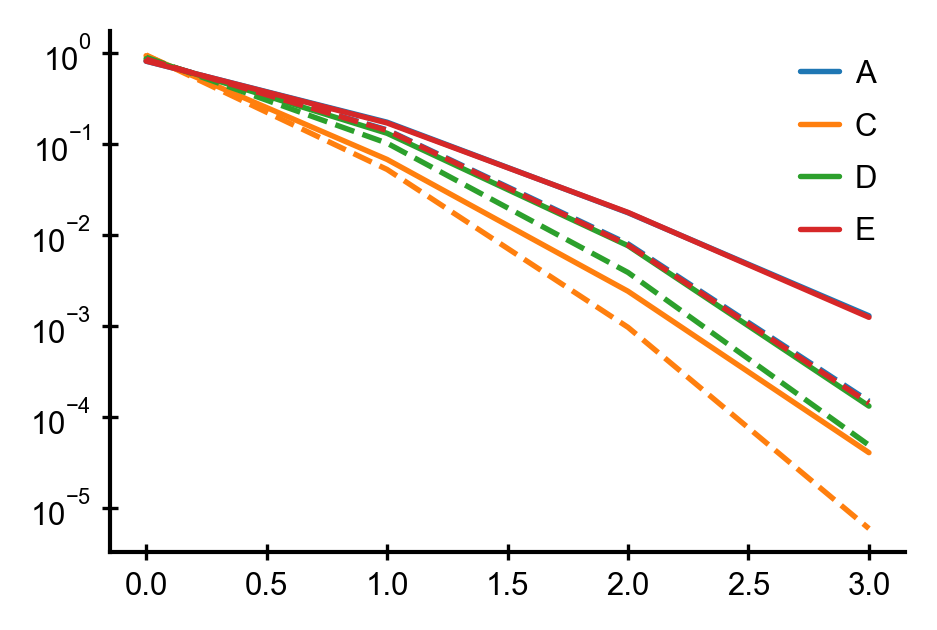

In [179]:
pseudocount = 1e-6
aafreqs = np.mean(np.asarray(aacountss), axis=0)/4
prob_aa_ks = prob_aa(aacountss, k, pseudocount=pseudocount)
for i in range(len(aminoacids)):
    aa = map_numbertoaa([i])[0]
    prob_aa_k = prob_aa_ks[i]
    print(aa, aafreqs[i], prob_aa_k)
    if i < 4:
        l, = plt.plot(prob_aa_k, label=aa)
        x = np.arange(0, k+1, 1)
        n = k
        p = aafreqs[i]
        plt.plot(x, binom.pmf(x, n, p), '--', c=l.get_color())
plt.legend()
plt.yscale('log')
fks = np.asarray(prob_aa_ks)

In [161]:
df4 = count(train, k)

kmers = [''.join(s) for s in itertools.product(aminoacids, repeat=k)]
df4_test = pd.DataFrame.from_dict(dict(seq=kmers, count=np.ones(len(kmers))))
df4_test.set_index('seq', inplace=True)
df4_count = counter_to_df(count_kmers_iterable(test, k), norm=False)
df4_count.set_index('seq', inplace=True)
df4_test = df4_test.add(df4_count, fill_value=0.0)
df4_test['freq'] = df4_test['count'] / np.sum(df4_test['count'])

m, jsd_test = calc_logfold(df4, df4_test)
jsd_flat = calc_jsd(df4_test['freq'], np.ones_like(df4_test['freq']), base=2)

tripletparams = calc_tripletmodelparams(train)
kmers = df4_test.index
df4_test['freq_ind'] = np.array([10**(loglikelihood_independent(s, **tripletparams)) for s in kmers])
df4_test['freq_mc'] = np.array([10**(loglikelihood_mc(s, **tripletparams)) for s in kmers])
df4_test['freq_tri'] = np.array([10**(loglikelihood_triplet(s, **tripletparams)) for s in kmers])
jsd_ind = calc_jsd(df4_test['freq'], df4_test['freq_ind'], base=2)
jsd_mc = calc_jsd(df4_test['freq'], df4_test['freq_mc'], base=2)
jsd_tri = calc_jsd(df4_test['freq'], df4_test['freq_tri'], base=2)

0.010897964608850834 0.004330712857986406 0.0006560602716436357


In [54]:
# evaluate empirical observables for fitting
df0 = count(train, 1)
df1 = count(train, 2, gap=0)
dfgap1 = count(train, 2, gap=1)
#dfgap2 = count(train, 2, gap=2)

In [55]:
h, Jk = fit_ising(df0, [df1, dfgap1], nmcmc=1e5, niter=10, epsilon=0.2, N=k, output=True)

[ 0.45583391 -0.65966922  0.06195008  0.46711346 -0.20365802  0.38743241
 -0.53224446 -0.03012386  0.24849105  0.80557161 -0.73964675 -0.21818239
  0.3494629   0.06753122  0.24014704  0.62725912  0.18191248  0.29630799
 -1.28896439 -0.51652418]
iteration 0
f1 1.7980113655344387e-05
f2, gap 0 0.0028484694647664304
f2, gap 1 0.002543765259393053
iteration 1
f1 1.909891196019059e-05
f2, gap 0 0.0021012734690487316
f2, gap 1 0.00204135343936187
iteration 2
f1 2.581531551959246e-05
f2, gap 0 0.0016414890433930139
f2, gap 1 0.0017588411425468627
iteration 3
f1 3.149932535818803e-05
f2, gap 0 0.0013222696028610996
f2, gap 1 0.001682078457705895
iteration 4
f1 2.37098776610066e-05
f2, gap 0 0.0009425092680246468
f2, gap 1 0.0014162282847352292
iteration 5
f1 3.3826509577924464e-05
f2, gap 0 0.0008713812455070927
f2, gap 1 0.0014788084147246757
iteration 6
f1 1.82518618672324e-05
f2, gap 0 0.0008719767237254431
f2, gap 1 0.0012051425125093342
iteration 7
f1 4.088294320124979e-05
f2, gap 0 0.000

In [164]:
Z = np.exp(scipy.special.logsumexp([-clib.energy(np.array(s), h, Jk) for s in itertools.product(range(naminoacids), repeat=k)]))
df4_test['freq_maxent'] = np.exp([-clib.energy(map_aatonumber(s), h, Jk) for s in kmers])/Z
jsd_maxent = calc_jsd(df4_test['freq'], df4_test['freq_maxent'], base=2)

In [75]:
hks = fit_global(fks, niter=3, nmcmc=2e5, epsilon=0.1)

In [202]:
niter=10
nmcmc=1e6
epsilon=10.0
prng=None
output=False

N = len(fks[0])-1
if prng is None:
    prng = np.random
q = len(aminoacids)
aas_arr = np.array(list(aminoacids))
hks = np.zeros((q, N+1))
for i in range(niter):
    if output:
        print('iteration %g'%i)
    def jump(x):
        xp = x.copy()
        i = np.random.randint(0, len(x))
        xp[i] = (xp[i]+np.random.randint(0, q-1))%q
        return xp
#    def jump(x):
#        return prng.randint(q, size=N)
    def energy(x):
        return energy_global(aacounts_int(x), hks)
    x0 = jump(prng.randint(q, size=N))
    samples = mcmcsampler(x0, energy, jump, nmcmc, prng=prng, nburnin=1e3)
    aacountss = [aacounts_int(s) for s in samples]
    prob_aa_ks = prob_aa(aacountss, N, pseudocount=pseudocount)
    hks += np.log(fks/prob_aa_ks)*epsilon
    #hks += (fks-prob_aa_ks)*epsilon
    jsd = calc_jsd(fks, prob_aa_ks, base=2)
    print(jsd)


[0.00077246 0.02835408 0.10252522 0.29745049]


KeyboardInterrupt: 

In [ ]:
plt.plot(fks.flatten(), prob_aa_ks.flatten(), 'o')
x = [1e-5, 1e0]
plt.plot(x, x, 'k')
plt.xscale('log')
plt.yscale('log')

In [195]:
Z = np.exp(scipy.special.logsumexp([-energy_global(aacounts_int(np.array(s)), hks) for s in itertools.product(range(naminoacids), repeat=k)]))
df4_test['freq_maxentglobal'] = np.exp([-energy_global(aacounts(s), hks) for s in kmers])/Z
jsd_maxentglobal = calc_jsd(df4_test['freq'], df4_test['freq_maxentglobal'], base=2)

In [196]:
print('4mer', 'test', jsd_test, 'maxent', jsd_maxent, 'maxentglobal', jsd_maxentglobal,
              'flat', jsd_flat, 'ind', jsd_ind, 'mc', jsd_mc, 'tri', jsd_tri)

4mer test 0.0004548957507683046 maxent 0.0026720994413888133 maxentglobal 0.010713706421513562 flat 0.11583779521335114 ind 0.010897964608850834 mc 0.004330712857986406 tri 0.0006560602716436357


In [184]:
from scipy.stats import gaussian_kde
def scatterplot(x, y, ax=None):
    if ax is None:
        ax = plt.gca()
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    ax.scatter(x, y, c=z, s=1, edgecolor='')

In [140]:
from scipy.interpolate import interpn
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs, logcolor=True)   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        ax = plt.gca()
    if logcolor:
        
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    return ax

SyntaxError: invalid syntax (<ipython-input-140-dbbdf9711b33>, line 2)

In [ ]:
# Generate fake data
x = np.random.normal(size=100000)
y = x * 3 + np.random.normal(size=100000)

fig, ax = plt.subplots()
scatter(x, y, ax=ax, s=1)
plt.show()

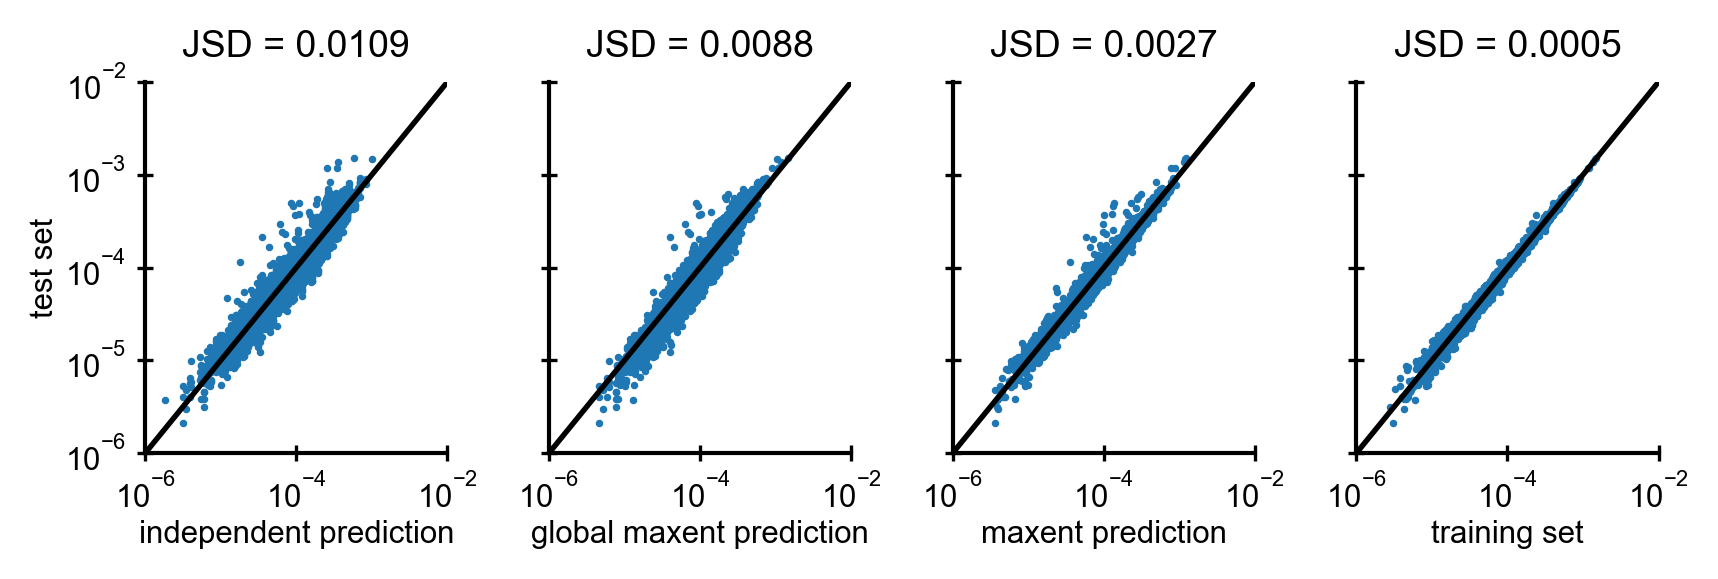

In [185]:
logscatter = False
#scatter = lambda x, y, ax: density_scatter(np.log10(x), np.log10(y), ax=ax, s=1, bins=100)
scatter = lambda x, y, ax: ax.scatter(x, y, s=1, alpha=1, edgecolor=None)
#scatter = lambda x, y, ax: ax.plot(x, y, 'o', ms=0.1, alpha=1)


fig, axes = plt.subplots(figsize=(5.8, 2.0), ncols=4, sharex=True, sharey=True)
ax = axes[0]
scatter(df4_test['freq_ind'], df4_test['freq'], ax)
ax.set_xlabel('independent prediction')
ax.set_ylabel('test set')
ax.set_title('JSD = %g'%round(jsd_ind, 4))
ax = axes[1]
scatter(df4_test['freq_maxentglobal'], df4_test['freq'], ax)
ax.set_xlabel('global maxent prediction')
#ax.set_ylabel('test set')
ax.set_title('JSD = %g'%round(jsd_maxentglobal, 4))
ax = axes[2]
scatter(df4_test['freq_maxent'], df4_test['freq'], ax)
ax.set_xlabel('maxent prediction')
#ax.set_ylabel('test set')
ax.set_title('JSD = %g'%round(jsd_maxent, 4))
ax = axes[3]
scatter(df4['freq'], df4_test['freq'], ax)
ax.set_xlabel('training set')
#ax.set_ylabel('test set')
ax.set_title('JSD = %g'%round(jsd_test, 4))
if logscatter:
    x = np.linspace(-8, -3)
else:
    x = np.logspace(-6, -2)
for ax in axes:
    ax.plot(x, x, 'k')
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(x), max(x))
    #plt.legend()
    if not logscatter:
        ax.set_xscale('log')
        ax.set_yscale('log')
fig.tight_layout()
fig.savefig('main.png', dpi=600)
#fig.savefig('main.svg')
#fig.savefig('main.pdf')

In [177]:
df4_test['freq_maxentglobal'].sum()

0.9999999999999996

In [186]:
print(4*np.log2(20),
      scipy.stats.entropy(df4_test['freq_ind'], base=2),
      scipy.stats.entropy(df4_test['freq_maxentglobal'], base=2),
      scipy.stats.entropy(df4_test['freq_maxent'], base=2),
      scipy.stats.entropy(df4_test['freq'], base=2),
     )

17.28771237954945 12.531732292067517 12.584080695323632 12.497181813942442 12.483591187682844


In [187]:
df4_test['freq_maxentglobal'].sort_values(ascending=False)

seq
SSS    0.001448
EEE    0.001164
AAA    0.001085
LLL    0.001044
PPP    0.000907
GGG    0.000786
LSS    0.000751
SSL    0.000751
SLS    0.000751
LLS    0.000688
LSL    0.000688
SLL    0.000688
ALL    0.000587
LLA    0.000587
LAL    0.000587
ALA    0.000584
AAL    0.000584
LAA    0.000584
GLL    0.000579
LGL    0.000579
LLG    0.000579
LEL    0.000569
LLE    0.000569
ELL    0.000569
LEE    0.000567
ELE    0.000567
EEL    0.000567
RRR    0.000560
PLL    0.000534
LLP    0.000534
         ...   
WHM    0.000009
HWM    0.000009
MWH    0.000009
WMM    0.000008
MWM    0.000008
MMW    0.000008
NWW    0.000008
WWN    0.000008
WNW    0.000008
WFW    0.000008
FWW    0.000008
WWF    0.000008
MCW    0.000008
WMC    0.000008
CMW    0.000008
CWM    0.000008
MWC    0.000008
WCM    0.000008
YWW    0.000006
WWY    0.000006
WYW    0.000006
HWW    0.000006
WHW    0.000006
WWH    0.000006
WWC    0.000005
CWW    0.000005
WCW    0.000005
WMW    0.000005
MWW    0.000005
WWM    0.000005
Name: freq_maxentglo

In [84]:
df4['freq'].sort_values(ascending=False)

seq
SSS    0.001469
LLL    0.001425
EEE    0.001338
PPP    0.001204
AAA    0.001154
SSL    0.000905
SLL    0.000898
LLS    0.000879
ALL    0.000856
LLA    0.000845
LSS    0.000826
LEE    0.000823
LSL    0.000804
SLS    0.000790
EEL    0.000787
LLE    0.000778
GGG    0.000763
LLG    0.000753
LAL    0.000741
ELL    0.000733
SSP    0.000721
LGL    0.000700
AAL    0.000699
LAA    0.000697
PGP    0.000682
LPP    0.000672
VLL    0.000671
SPS    0.000669
GSS    0.000667
PSS    0.000666
         ...   
HWM    0.000007
HMW    0.000007
YMW    0.000006
WYC    0.000006
WMC    0.000006
MWH    0.000006
WYW    0.000006
WWY    0.000006
MYW    0.000006
HWW    0.000006
WWW    0.000006
YWW    0.000006
NWW    0.000006
WCW    0.000005
MCW    0.000005
MMW    0.000005
WWH    0.000005
WFM    0.000005
CMW    0.000005
WHM    0.000005
WMY    0.000004
MWC    0.000004
WWC    0.000004
MWM    0.000004
WWM    0.000004
WMW    0.000004
WHW    0.000004
CWW    0.000003
MWW    0.000003
WCM    0.000003
Name: freq, Length: 